In [1]:
"""
#### Code adapted from the source code of ArtEmis dataset paper
"""

import json
import torch
import pandas as pd
import os.path as osp
import numpy as np
import itertools
from PIL import Image
from model.func_eval import unpickle_data,torch_load_model
from artemis.utils.vocabulary import Vocabulary #Use for text2emotion metrics
from artemis.evaluation.single_caption_per_image import apply_basic_evaluations
from artemis.emotions import IDX_TO_EMOTION
%load_ext autoreload
%autoreload 2

In [2]:
DBdir = "../Dataset/ArtEmis/ArtEmis_IdC"
modelname = 'CLIPViTB16_full' #'CLIPViTB16_full','CLIPViTB16_woSG','INRN34_full','INRN34_woSG','INViTB16_full','INViTB16_woSG'

model_dir = f'output/{modelname}'
sampled_captions_file = osp.join(model_dir,'fullDB_test.pkl')

In [3]:
references_file = osp.join(DBdir,'Artemis_IdCI_GT.pkl')
split = 'test'
gpu_id = 0

# the evaluation of the longest-common-subsequence is quite slow -- so we sub-sampled the data:
default_lcs_sample = [25000, 800]
# First integer (25000) = number of training (gt) sentences to subsample from all training
# Secong integer (800)  = number of sample sentences to subsample from all generations

In [4]:
gt_data = next(unpickle_data(references_file))
train_utters = gt_data['train']['references_pre_vocab']
train_utters = list(itertools.chain(*train_utters))  # undo the grouping per artwork to a single large list
print('Training Utterances', len(train_utters))
unique_train_utters = set(train_utters)
print('Unique Training Utterances', len(unique_train_utters))

# now focus on the data (split) that you created captions for
gt_data = gt_data[split]
print('Images Captioned', len(gt_data))

device = "cpu"

Training Utterances 75509
Unique Training Utterances 75448
Images Captioned 2497


In [5]:
evaluation_methods = {'bleu', 'meteor', 'rouge'}
print(evaluation_methods) 

{'rouge', 'meteor', 'bleu'}


In [6]:
saved_samples = next(unpickle_data(sampled_captions_file))

for sampling_config_details, captions in saved_samples:  # you might have sampled under several sampling configurations
    merged = pd.merge(gt_data, captions)  # this ensures proper order of captions to gt (via accessing merged.captions)
    hypothesis = merged.captions_predicted
    references = merged.references_pre_vocab # i.e., use references that do not have <UNK>

    metrics_eval = apply_basic_evaluations(hypothesis, references, None, None, None, 
                                           nltk_bleu=False, lcs_sample=default_lcs_sample,
                                           train_utterances=unique_train_utters,
                                           methods_to_do=evaluation_methods)

    print(pd.DataFrame(metrics_eval))
    print()

BLEU: done
COCO-based-metrics: done
   metric      mean       std
0  BLEU-0  0.612882  0.167877
1  BLEU-1  0.409091  0.189524
2  BLEU-2  0.267766  0.214982
3  BLEU-3  0.182296  0.180550
4  METEOR  0.187614  0.061602
5   ROUGE  0.366526  0.115325



In [7]:
# Load weights of promCLIP
from clip import clip
from model.promCLIP import promCLIP as promCLIP_model
from model.func_train import load_state_dicts
CLIP_name = 'RN50x16'
no_promt_tokens=3
FTpromCLIP_dir = "output/promCLIP/NP3_RN50x16/checkpoints"

orig_CLIP,CLIPtransform,CLIPsettings = clip.load(CLIP_name,device)
embed_dim,image_resolution, vision_layers, vision_width, vision_patch_size,context_length_CLIP, vocab_size_CLIP, transformer_width, transformer_heads, transformer_layers = CLIPsettings
promCLIP = promCLIP_model(embed_dim,image_resolution,vision_layers,vision_width,
            vision_patch_size,no_promt_tokens,context_length_CLIP,
            vocab_size_CLIP,transformer_width,transformer_heads,transformer_layers)

loaded_epoch = load_state_dicts(osp.join(FTpromCLIP_dir,  'best_model.pt'), map_location='cpu', model=promCLIP)
print("load model at epoch=",loaded_epoch)

load model at epoch= 55


In [8]:
# Calculate promCLIP indexes of generated captions
from PIL import Image
from torchvision.transforms import Compose, ToTensor
similarities = []
img_dir = f'../Dataset/ArtEmis/ArtEmis_IdC/Images/CLIP_{image_resolution}/'
img_transform = Compose([ToTensor()])
for i,row in merged.iterrows():
    img_file = osp.join(img_dir, row.art_style,  row.painting + '.jpg')
    image_inputs = torch.unsqueeze(img_transform(Image.open(img_file)), 0)
    capt = row['captions_predicted']
    prompt = f'{capt}'
    text_inputs = clip.tokenize(prompt)
    with torch.no_grad():
        _,score = promCLIP(image_inputs.to(device),text_inputs.to(torch.long).to(device))
    similarities.append(score.squeeze(0).tolist())
promCLIP_score = np.mean((np.array(similarities)))
promCLIP_score

26.504742872156427

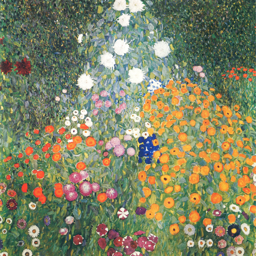

Generated Caption: the bright colors of the flowers make me think of spring 
Ground-truth captions: ['this serene field of flowers has many bright and vivid colors that flow so well together and makes you feel as though you are in another world', 'the bright colors on the flowers look like a happy spring day', 'i am not liking the lack of talent here i do not like the lack of detail that was put into the flowers the <unk> seem to be too off', 'this feels like a warm sunny day in a garden surrounded by the gentle perfume of flowers', 'it is a field of flowers with a nice range of color with nobody around this seems like it would be a nice area to relax and be carefree', 'it reminds me of an english garden full of flowers in bloom very cheerful', 'i feel joy looking at this painting the color in the leaves and grass bring an <unk> <unk> of <unk> the greens yellows and blues meld so perfectly the flowers themselves are gorgeous and make me feel as though i am in the field myself', 'the ma

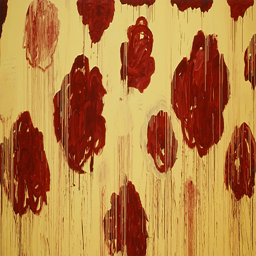

Generated Caption: the red color of the flowers remind me of blood 
Ground-truth captions: ['the dark red looks like dried blood', 'the red smears look like <unk> of blood', 'this looks like red clouds in the sky which is something to see so wing', 'because the dripping red ( possibly ) flowers look like blood spatter <unk> that were running down the wall'] 



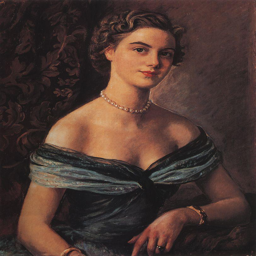

Generated Caption: the woman looks like she is posing and confident to be seductive 
Ground-truth captions: ['the texture and facial expression make her look like a porcelain doll', 'a portrait of a woman that seems to be mildly attractive with lots of detail', 'lovely portrait of a young woman with good postures who does not look as though she posing against her will and has an actual smile', 'this is a stunning painting of a young woman in an elegant dress string of pearls <unk> accessories and well <unk> hair that reminds me of a <unk> who is classy but <unk>', 'the lady looks like she is ready to go to a party and she is thinking that she looks pretty good all dressed up', 'the woman looks like she is happy and calm'] 



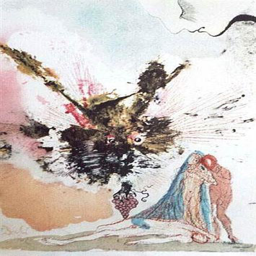

Generated Caption: the colors are very vivid and the painting looks like a bird 
Ground-truth captions: ['there seems to be an explosion of a bird with black paint which looks disgusting', 'i am not sure what is going on here the people almost look sad but it looks like something exploded above them too', 'the blob in the center of the painting looks like it has open eyes it is really disturbing', 'it looks like there is a pair of eyes watching this couple from behind a mask of darkness', 'i am a bit unsure of what is happening but an individual appears to have been seriously hurt at the bottom it feels like a deity has been angered or <unk>'] 



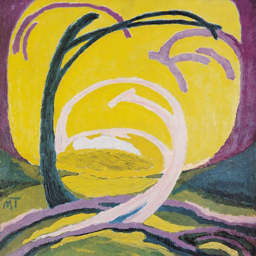

Generated Caption: the yellow and green remind me of a sunset 
Ground-truth captions: ['it looks like a large sun in the background', 'reminds me of a haunted forrest', 'the white lines are like wind flowing through a forest', 'for some reason this is a relaxing dreamy painting it looks like you are looking into a majestic wooded tunnel during sunset'] 



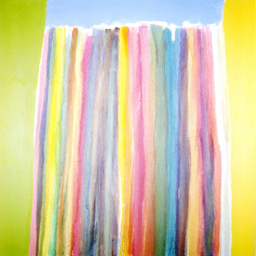

Generated Caption: the colors remind me of a rainbow 
Ground-truth captions: ['it looks like a bunch of different colored rubber bands on the wrist of someone', 'the stripes of color are like a rainbow waterfall', 'all the colors are so cheerful this almost makes me laugh out loud it is like a candy waterfall', 'pastel colors that look like a rainbow and remind me of easter'] 



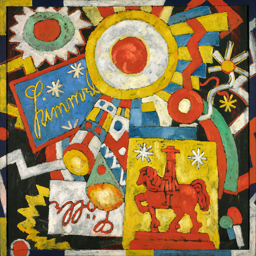

Generated Caption: the bright colors and yellows remind me of a carnival 
Ground-truth captions: ['the bright colors and patterns make it look like a party', 'reminds me of an advertisement for spain or mexico with the bright colors and geometric designs', 'the stars colors and overall clutter remind me of chinese new year', 'this looks like a pile of ads for a fair with ribbons for <unk> and elaborate candies between the signs the colors make you excited'] 



In [9]:
img_dir = '../Dataset/ArtEmis/ArtEmis_IdC/Images/rawImages/'
for random_id in [321,21,1031,208,1038,612,685]:
    row = merged.iloc[random_id]
    img_file = osp.join(img_dir, row['art_style'], row['painting'] + '.jpg')
    image = Image.open(img_file).resize((256, 256))
    display(image)
    print("Generated Caption:",row['captions_predicted'],"\nGround-truth captions:",row['references'],"\n") 

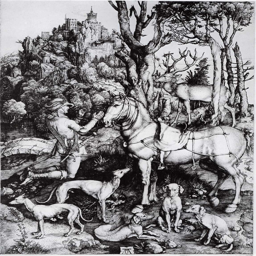

Generated Caption: the painting looks like a scene of a fairy tale 
Ground-truth captions: ['the lines in this drawing makes it look like its moving in action', 'the grim setting seems to be harboring some evil within it', 'the detail in this is amazing it looks like it is pencil drawn and not painted the animals all have very distinct facial expressions', 'the dogs look like they are feeling sorry for the horse that is tied up with ropes', 'this picture is only black and white but has so much going on in it it reminds me of a fairy tale with so many animals and the castle on the hill'] 



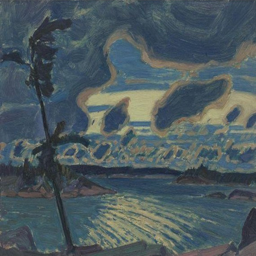

Generated Caption: the dark colors make it look like a storm is brewing 
Ground-truth captions: ['this landscape is beautiful but also <unk> a desolate and isolated feel like windswept islands', 'the clouds in this make it look like there is a hurricane or tropical storm on the way', 'the dark clouds overhead remind me of a hurricane hitting an island', 'this painting makes me fearful because it looks like the end of the world', 'as indicated by the bent tree it is windy the skies are dark it looks like a storm is coming', 'the dark colors and clouds make it seem like a storm is coming'] 



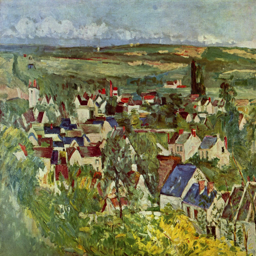

Generated Caption: the colors are bright and the village look like a nice place to live 
Ground-truth captions: ['the town looks like it is nestled in the <unk> rolling fields', 'it seems like a very peaceful pastoral view it is just missing the wagon', 'i see the hills in background and the village before me as if i was on a journey and now returning home so content', 'colorful rooftops in the village below looks like springtime'] 



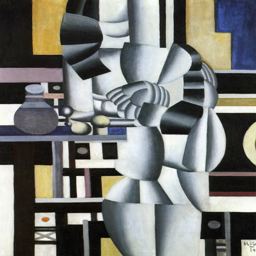

Generated Caption: the colors are very vivid and the painting looks like a robot 
Ground-truth captions: ['it looks like a robot mixing up something that will make it fall to pieces and come back together', 'reminds me of those old pop modern pieces i like those', 'there seems to be a human figure in the painting that is all out of shape and broken', 'the black and white and gray colors make it look like a person is standing on a table it looks like a club'] 



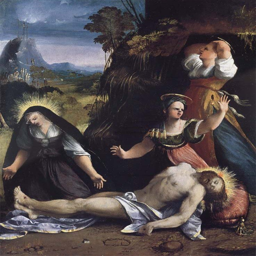

Generated Caption: the man in the middle looks like he is dying 
Ground-truth captions: ['i guess their grief may be true but it feels like they are being over dramatic', 'the man who is lying on the ground looks like he is dying and can not be <unk>', 'the man who is laying down on the ground looks like he is dying i feel bad for him and the people around him', "the yellow sparks coming off the people 's heads emphasizes how upset they are about the man dying the woman holding her head seems to be in disbelief", 'i feel a sad because the man laying down seems to have died i feel that way because of the expression of the three woman surrounding him they all seem to be in some form of distress', "i feel like the subject matter of the painting ( christ 's death ) has been spoilt by the distorted facial expressions of some of the figures", 'the people in the painting make me feel heartache this looks like jesus and they seem to be sad', 'a paint of taking christ down from the cross my fee

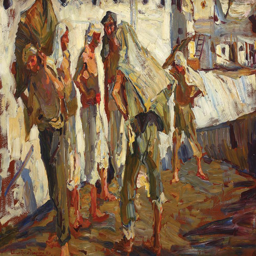

Generated Caption: the people look like they are having a hard time 
Ground-truth captions: ['these men look exhausted as if they are working too hard', 'it looks like these folks are slaves or <unk> servants forced to work here pretty sad and upsetting to see', 'i feel fear because of the darker colors used within the picture provided a gloominess there is also a lot of red used on their faces and bodies which looks like blood', 'the people lined up against the wall look like they are being <unk> there is a person with fierce posture with a weapon on their side who is cowering at another who is huddled away the blurry brush strokes lack detail and make you imagine it', 'these men in their ragged pants and no shirts are like sailors without a ship', 'this looks like people out in the heat talking by a work site i love how blurred the details are while colors all blend <unk>', 'the strong and somewhat jagged strokes uses to depict the people give them an angry look as though they are in

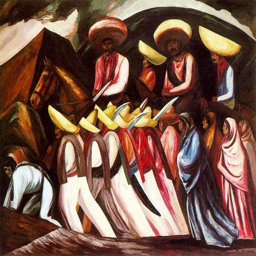

Generated Caption: the colors are very vivid and the people look like they are in a cult 
Ground-truth captions: ['looks like the men on horses are marching everyone to their deaths and the <unk> of the women is pretty chilling', 'this gives me an adventurous feel like an old western movie', 'looks like a grueling journey it looks <unk> to me', 'the vibrant colors make me feel like i am in mexico'] 



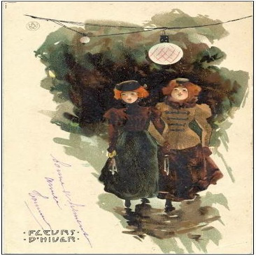

Generated Caption: the two girls look like they are having a good time 
Ground-truth captions: ['i feel like these ladies are leaving the lights and walking home in the dark', 'nice painting of what looks like sisters out in a clear night', 'they look like sisters dressed and ready to party', 'the string lights feel like they are going to a fun party or event facial expressions seem happy'] 



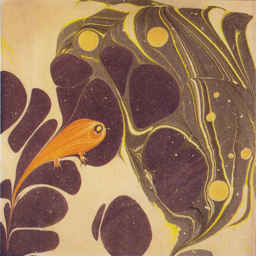

Generated Caption: the bananas on the butterfly looks like a fish 
Ground-truth captions: ['it looks like an orange fish trying to swim through the water polluted with chemicals', 'the colored blobs look like water drops on a plate of glass', 'this creature moves within this foliage so <unk> that it almost seems to be a part of it', 'the fish looks like he is getting ready to swim into a hole', 'the green glob looks like an eerie monster about to <unk> up the <unk> creature', 'the small orange fish seems to be swimming through obstacles under water the fish seems to have a great fighting spirit', 'the black splotches look like windows into the galaxy', 'it looks like a fish is about to be consumed by a monster with many mouths', 'the mix of black and yellow paints make things look like they are in motion the orange creature is hard to see', 'the fish looks like it is swimming towards a black whole', 'the fish looks like a <unk> since it <unk> has legs', 'the fish looks like it ’ s look

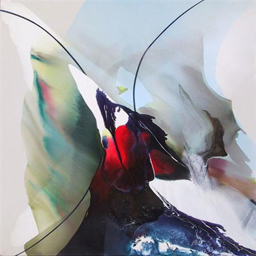

Generated Caption: the colors are very vivid and the painting looks like a bird 
Ground-truth captions: ['no idea what it is supposed to be but the colors feel like they show movement or activity', 'i really line the bright red in the center of the piece it pops out against the pastels and really makes this attractive to look at this reminds me of an easter morning and a butterfly as it looks like it has wings', 'this looks like a butterfly that is getting ready to take flight', 'the dark blue contrasts well with the red in the painting the blue makes it look like a river and the pale colors look like the side of cliffs'] 



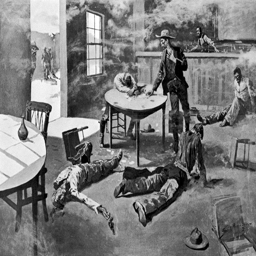

Generated Caption: the man on the bed looks like he is dying 
Ground-truth captions: ['the darkness of the photo makes it seem like the aftermath of a fight', 'the people look like they are hurt or in pain since they are laying on the ground', 'the men look like they were in a <unk> or drunk passed out', 'i dont mind the imagery as it reminds me of my favorite movie <unk> however at its root is violence death and <unk> the monochrome pallette is perfect for the subject matter'] 



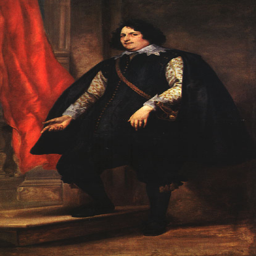

Generated Caption: the woman looks like a queen 
Ground-truth captions: ['the man looks as if he is signaling to something on the ground and i wonder what he is saying', 'there is some <unk> to this even though it is a portrait there seems to be movement', 'he looks like a very peaceful gentleman who talks with a deep worldly accent and that is comforting', 'the red and black reminds me of anger the man looks stern'] 



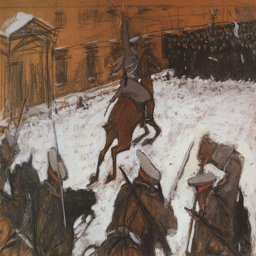

Generated Caption: the man looks like he is about to attack 
Ground-truth captions: ['it looks like these soldiers are trying to take down a tree that stole a horse', 'it looks like these people are about to be attacked by sword <unk> soldiers quite scary', 'angry soldiers ready for a bloody battle their jagged lines look like rage is within them', 'these men look like they are about to enter battle'] 



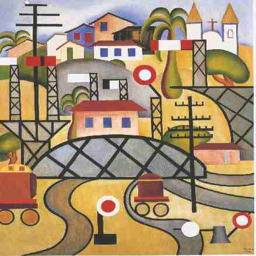

Generated Caption: the colors and shapes make it look like a city 
Ground-truth captions: ['the suppleness of the shapes used for the objects reminds me of toy cars and those rugs that are made to look like maps', 'it looks like a puzzle game that makes me think of it', 'makes me feel like i am looking at a newly built modern city in an old desert city', 'this piece reminds me of a childhood tv show with the bright colors and the <unk> carts and all the different traffic signs i love the block work to the city as if your expecting a cartoon train to come around the corner', 'i want to visit this town it looks like <unk> fun place'] 



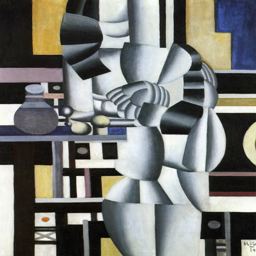

Generated Caption: the colors are very vivid and the painting looks like a robot 
Ground-truth captions: ['it looks like a robot mixing up something that will make it fall to pieces and come back together', 'reminds me of those old pop modern pieces i like those', 'there seems to be a human figure in the painting that is all out of shape and broken', 'the black and white and gray colors make it look like a person is standing on a table it looks like a club'] 



In [10]:
img_dir = '../Dataset/ArtEmis/ArtEmis_IdC/Images/rawImages/'
for random_id in [1564,336,1315, 665, 1052, 1365,874,420, 358,125, 1905,456,436, 1529, 665]:
    row = merged.iloc[random_id]
    img_file = osp.join(img_dir, row['art_style'], row['painting'] + '.jpg')
    image = Image.open(img_file).resize((256, 256))
    display(image)
    print("Generated Caption:",row['captions_predicted'],"\nGround-truth captions:",row['references'],"\n") 
    
    
